In [ ]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [39]:
# load invoice raw table
invoice = pd.read_csv('data/raw/invoice_train.csv')
# remove rows double
invoice[invoice.duplicated(keep=False)]
invoice = invoice.drop_duplicates()
print("Don't mind the warning, reading_remaked is mixed string and integer")

C:\Users\mannt\AppData\Local\Temp\ipykernel_38932\3810403740.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice = pd.read_csv('data/raw/invoice_train.csv')


Don't mind the warning, reading_remaked is mixed string and integer


In [40]:
# correct column names
# 'counter_status' is 'counter_status'
invoice.rename(columns={'counter_statue': 'counter_status'}, inplace=True)
# reading_remarque is reading_remark
invoice.rename(columns={'reading_remarque': 'reading_remark'}, inplace=True)
# any column with "consommation is "consumption"
invoice.columns = invoice.columns.str.replace('consommation', 'consumption')
# tarif is tariff
invoice.columns = invoice.columns.str.replace('tarif', 'tariff')
# obviously, names made in french speaking african country...
invoice.columns

Index(['client_id', 'invoice_date', 'tariff_type', 'counter_number',
       'counter_status', 'counter_code', 'reading_remark',
       'counter_coefficient', 'consumption_level_1', 'consumption_level_2',
       'consumption_level_3', 'consumption_level_4', 'old_index', 'new_index',
       'months_number', 'counter_type'],
      dtype='object')

In [41]:
# add traget and client_id to invoive data
client_info = pd.read_csv('data/raw/client_train.csv')
client_info = client_info[['client_id', 'target']]
invoice = invoice.merge(client_info, on='client_id', how='left')

In [42]:
# get unique combinations of counter_number and counter_code, per counter type
counter_combinations = invoice.groupby(['counter_number', 'counter_code', 'counter_type'])

# get unique client_id for counter_combinations
unique_clients = counter_combinations['client_id'].nunique()
unique_clients.sort_values(ascending=False)

counter_number  counter_code  counter_type
0               5             GAZ             5080
                10            GAZ               37
                25            GAZ               16
1111            5             GAZ               16
0               413           ELEC               6
                                              ... 
263372          207           ELEC               1
263373          207           ELEC               1
263375          203           ELEC               1
263376          207           ELEC               1
27981145458733  203           ELEC               1
Name: client_id, Length: 219457, dtype: int64

In [43]:
# Rows with combination counter_number=0, counter_code = 5, target=1
invoice[(invoice['counter_number'] == 0) & (invoice['counter_code'] == 5) & (invoice['target'] == 1)]
# strange ~ 3500 fraud rows with same counter_number and counter_code combination

# how many cliends have this combination in total?
unique_clients[(unique_clients.index.get_level_values('counter_number') == 0) & (unique_clients.index.get_level_values('counter_code') == 5)]
# >5000 clients have this combination for Gas counters

counter_number  counter_code  counter_type
0               5             GAZ             5080
Name: client_id, dtype: int64

In [44]:
# get date, month and year right
invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date']).dt.date
invoice['year'] = pd.to_datetime(invoice['invoice_date']).dt.year
invoice['month'] = pd.to_datetime(invoice['invoice_date']).dt.month

In [45]:
for col in invoice.columns:
    if invoice[col].nunique() < 30:
        print(f'{col}: {invoice[col].unique()}')

tariff_type: [11 40 15 10 12 14 13 45 29  9 30  8 21 42 27 18 24]
counter_status: [0 1 5 4 3 2 769 '0' '5' '1' '4' 'A' 618 269375 46 420]
reading_remark: [  8   6   9   7 207 413 203   5]
counter_coefficient: [ 1  3  0 10  4 33 50 20  2  6 40  9 30  5 11  8]
counter_type: ['ELEC' 'GAZ']
target: [0. 1.]
month: [ 3  7 11 12  2 10  6  1  9  5  4  8]


In [46]:
# homogenize counter_status: [0 1 5 4 3 2 769 '0' '5' '1' '4' 'A' 618 269375 46 420]
# Create a dictionary for mapping counter_status values
counter_status_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5
}

# Map the values using the dictionary to replace them with integers
# rows counter_status unclear - can go Nan and be imputedn NO Frauds
print(invoice[invoice['counter_status'] == "A"]) # one client, no fraud
print(invoice[invoice['counter_status'] == "269375"]) # one row, no fraud
print(invoice[invoice['counter_status'] == "618"]) # one client, no fraud
print(invoice[invoice['counter_status'] == "46"]) # one client, no fraud
print(invoice[invoice['counter_status'] == "769"]) # one client, no fraud
print(invoice[invoice['counter_status'] == "420"]) # one row, no fraud

                  client_id invoice_date  tariff_type  counter_number   
1923229  train_Client_30467   2011-11-07           15         9505424  \
1923235  train_Client_30467   2007-04-17           15         9505424   
1923238  train_Client_30467   2005-11-08           15         9505424   
1923239  train_Client_30467   2006-11-12           15         9505424   
1923240  train_Client_30467   2012-10-07           15         9505424   
1923245  train_Client_30467   2012-03-13           15         9505424   
1923249  train_Client_30467   2006-04-18           15         9505424   
1923265  train_Client_30467   2006-08-14           15         9505424   
1923268  train_Client_30467   2012-11-13           15         9505424   
1923269  train_Client_30467   2007-11-12           15         9505424   
1923270  train_Client_30467   2010-09-11           15         9505424   
1923271  train_Client_30467   2011-03-16           15         9505424   
1923274  train_Client_30467   2005-09-12           

In [47]:
invoice['counter_status'] = invoice['counter_status'].replace(['A', 269375, 618, 46, 769, 420], np.nan)
invoice['counter_status'] = pd.to_numeric(invoice['counter_status'], errors='coerce').astype('Int64')

In [48]:
# [ 10  50 20  40  30 ]
# all rows of invoice with counter_coefficient >9
invoice[invoice['counter_coefficient'] > 9]
# how many clients have counter_coefficient >9 per target group?
clients_with_high_coefficient = invoice[invoice['counter_coefficient'] > 9].groupby('target')['client_id'].nunique()
print(clients_with_high_coefficient,"\n\n\n")
# show the client with counter_coefficient larger 9 and target=1
clients_with_high_coefficient = invoice[(invoice['counter_coefficient'] > 9) & (invoice['target'] == 1)]
print(clients_with_high_coefficient, "\n\n\n")

# show the client with counter_coefficient larger 9 and target=0
clients_with_high_coefficient = invoice[(invoice['counter_coefficient'] > 9) & (invoice['target'] == 0)]
print(clients_with_high_coefficient)

target
0.0    11
1.0     1
Name: client_id, dtype: int64 



                  client_id invoice_date  tariff_type  counter_number   
700544  train_Client_118876   2006-10-25           11          160600  \

        counter_status  counter_code  reading_remark  counter_coefficient   
700544               1           410               6                   10  \

        consumption_level_1  consumption_level_2  consumption_level_3   
700544                  600                  580                    0  \

        consumption_level_4  old_index  new_index  months_number counter_type   
700544                    0          0          0              2         ELEC  \

        target  year  month  
700544     1.0  2006     10   



                   client_id invoice_date  tariff_type  counter_number   
296474   train_Client_108022   2005-12-23           11          131494  \
438874   train_Client_111792   2006-03-11           11            1566   
658126    train_Client_11774   2011-06-28

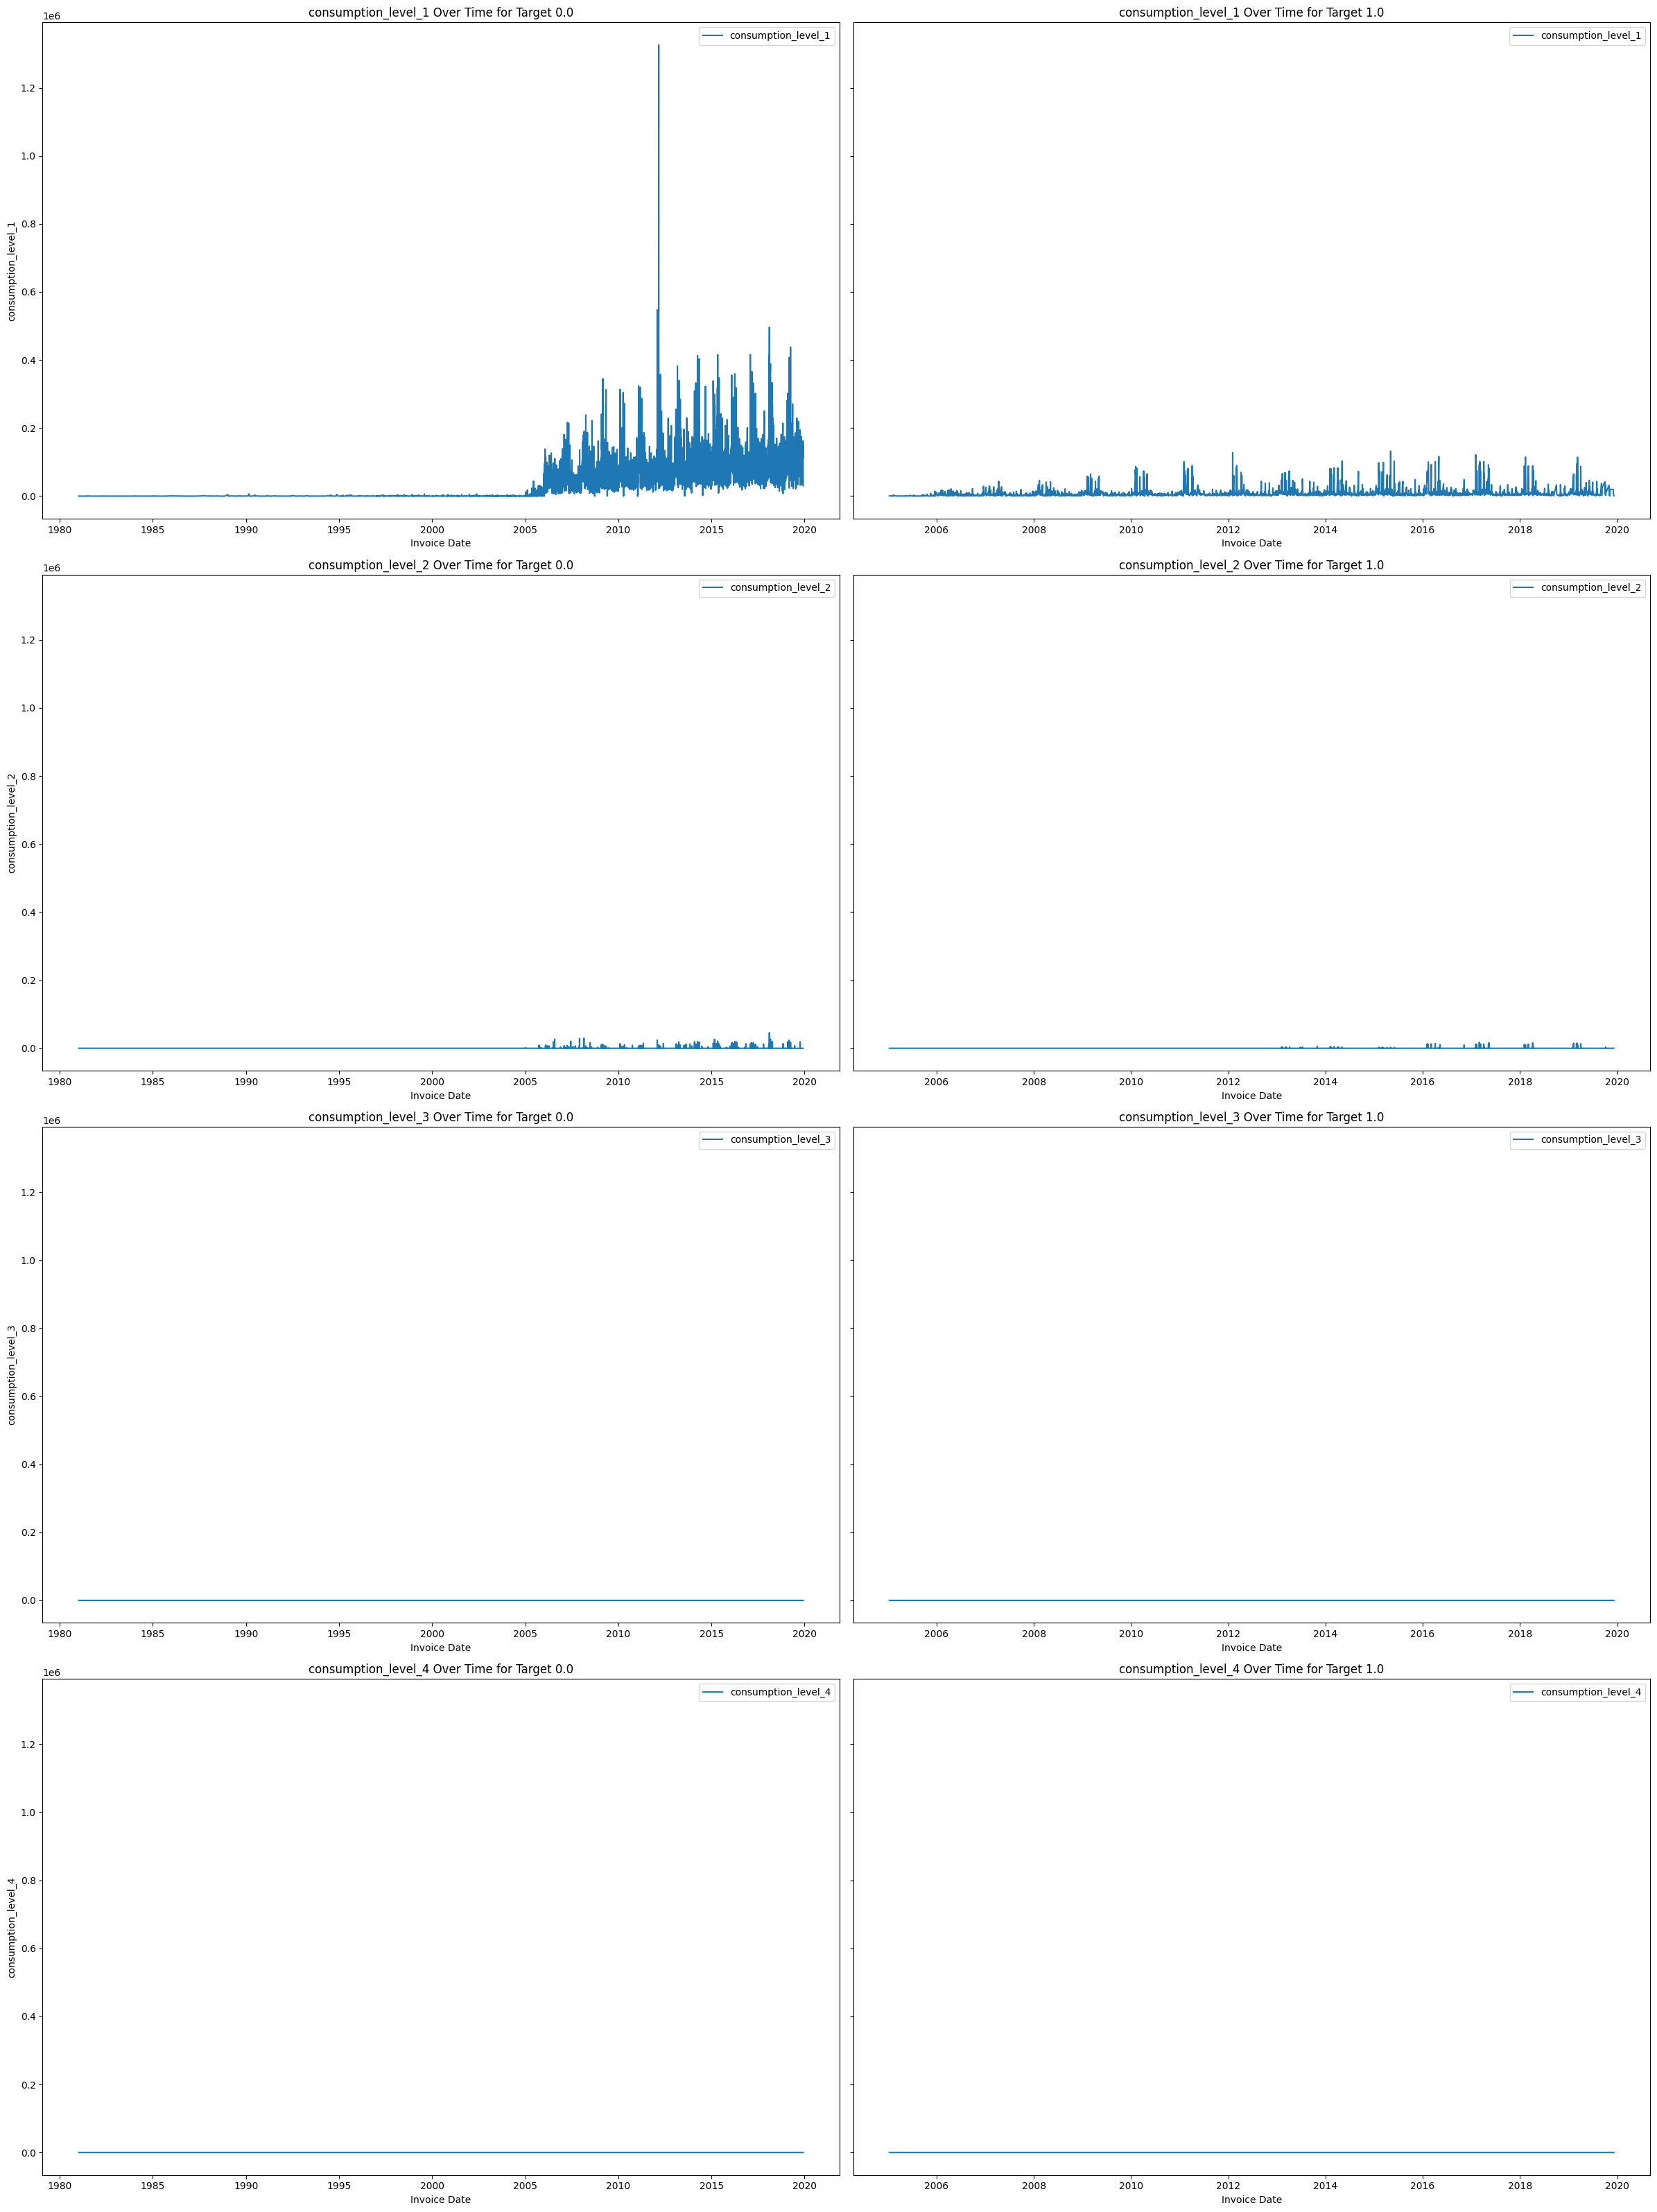

In [49]:
# Create a subset of the invoice data where counter_type is 'GAZ'
invoice_gaz = invoice[invoice['counter_type'] == 'GAZ']

# plot invoice_gaz consumption columns over time
consumption_columns = [col for col in invoice_gaz.columns if 'consumption' in col]

# Plot each consumption column over time side by side for each target
fig, axes = plt.subplots(len(consumption_columns), 2, figsize=(24, 8 * len(consumption_columns)), sharey=True)

for i, column in enumerate(consumption_columns):
    for j, target in enumerate(invoice_gaz['target'].unique()):
        ax = axes[i, j]
        invoice_gaz[invoice_gaz['target'] == target].groupby('invoice_date')[column].sum().plot(ax=ax)
        ax.set_title(f'{column} Over Time for Target {target}')
        ax.set_xlabel('Invoice Date')
        ax.set_ylabel(column)
        ax.legend([column])

plt.tight_layout()
plt.show()

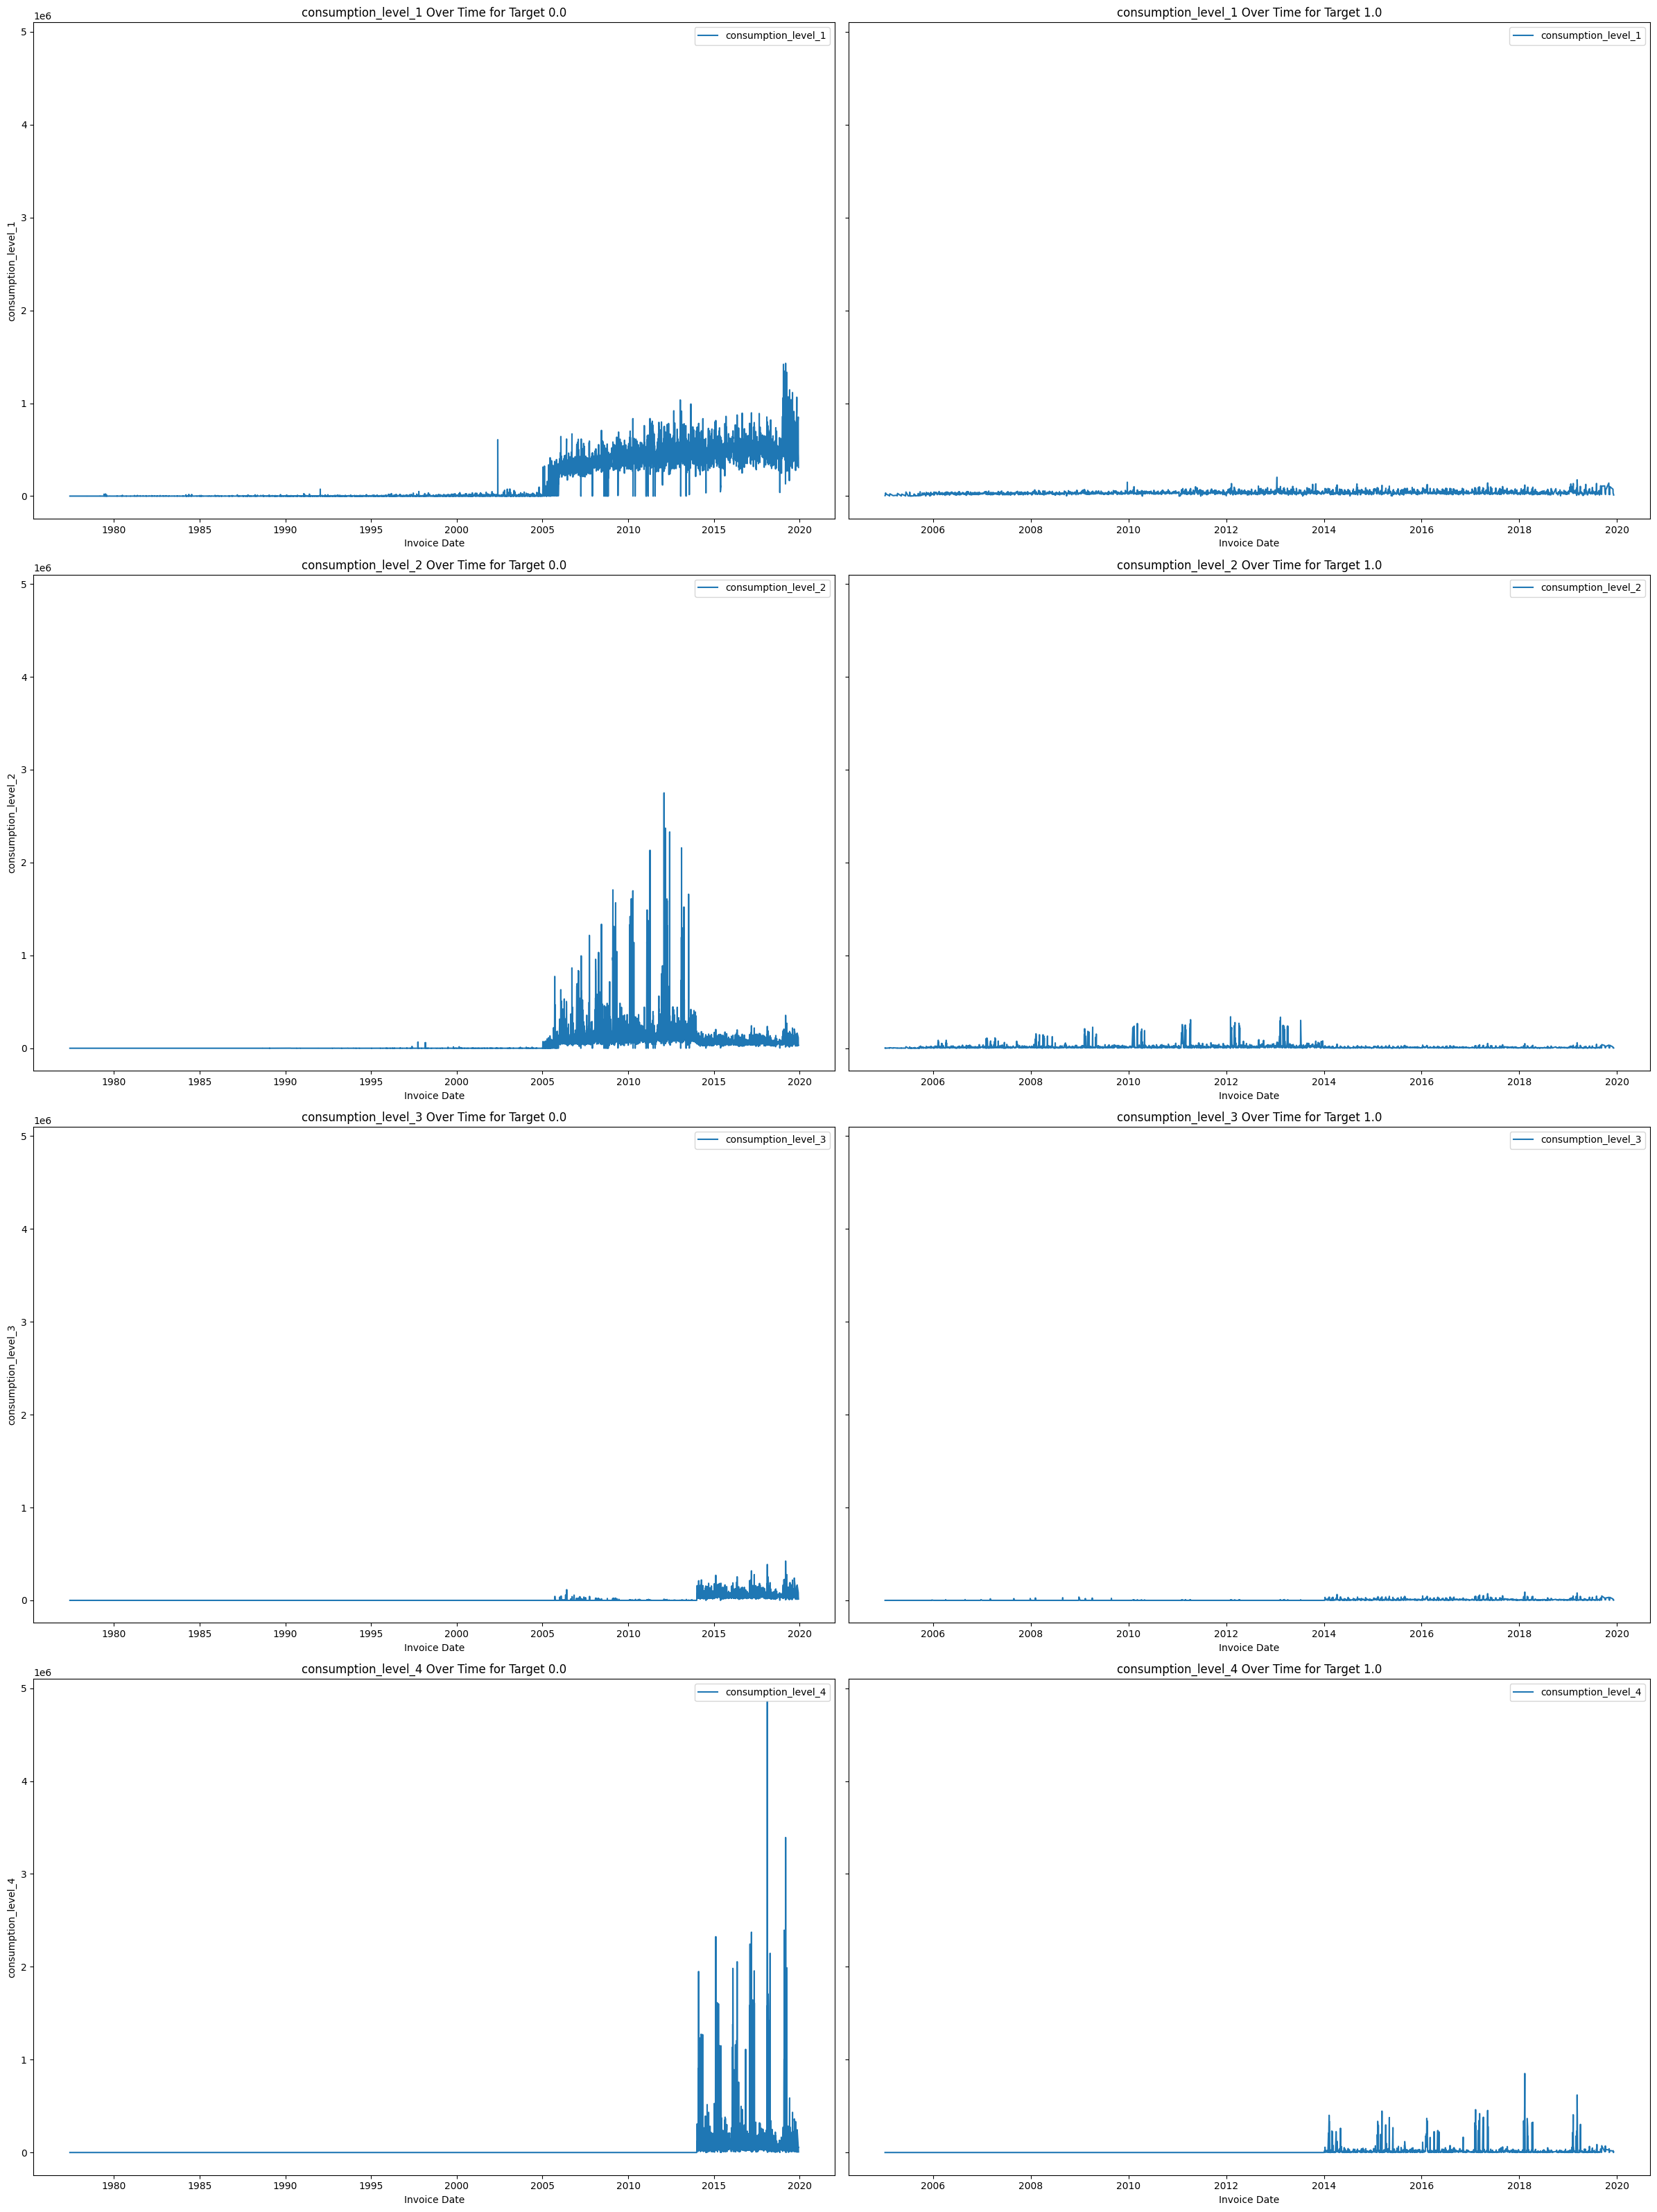

In [50]:
invoice_elec = invoice[invoice['counter_type'] == 'ELEC']

# plot invoice_elec consumption columns over time
consumption_columns = [col for col in invoice_elec.columns if 'consumption' in col]

# Plot each consumption column over time side by side for each target
fig, axes = plt.subplots(len(consumption_columns), 2, figsize=(24, 8 * len(consumption_columns)), sharey=True)

for i, column in enumerate(consumption_columns):
    for j, target in enumerate(invoice_elec['target'].unique()):
        ax = axes[i, j]
        invoice_elec[invoice_elec['target'] == target].groupby('invoice_date')[column].sum().plot(ax=ax)
        ax.set_title(f'{column} Over Time for Target {target}')
        ax.set_xlabel('Invoice Date')
        ax.set_ylabel(column)
        ax.legend([column])

plt.tight_layout()
plt.show()
# dont kno what to make from this....

In [51]:
for counter_type in invoice['counter_type'].unique():
    print(f'\nCounter Type: {counter_type}')
    subset = invoice[invoice['counter_type'] == counter_type]
    for col in subset.columns:
        if subset[col].nunique() < 35:
            print(f'{col}: {subset[col].unique()}')


Counter Type: ELEC
tariff_type: [11 15 10 12 14 13 29  9  8 21 27 18 24]
counter_status: <IntegerArray>
[0, 1, 5, 4, 3, 2, <NA>]
Length: 7, dtype: Int64
reading_remark: [  8   6   9   7 207 413 203]
counter_coefficient: [ 1  3  0 10  4 50 20  2  6 40  9 30  8]
counter_type: ['ELEC']
target: [0. 1.]
month: [ 3  7 11 12  2 10  6  1  9  5  4  8]

Counter Type: GAZ
tariff_type: [40 45 30 42]
counter_status: <IntegerArray>
[0, 1, 5, 4, 2, 3, <NA>]
Length: 7, dtype: Int64
counter_code: [ 5 10 25 40 65 16  1]
reading_remark: [9 8 6 7 5]
counter_coefficient: [ 1 33 10  0  4  5 11  6]
consumption_level_3: [0]
consumption_level_4: [0]
counter_type: ['GAZ']
target: [0. 1.]
month: [12  1  9  5  7 11  3  8 10  4  2  6]


In [52]:
# show rows where reading_remarque 207, 413, 203
invoice[invoice['reading_remark'] == 207] # one client, no fraud
invoice[invoice['reading_remark'] == 413] # one client, no fraud
invoice[invoice['reading_remark'] == 203] # 2 clients, no fraud
# Dont think we should set them to Nan, maybe the model needs shitty data to learn from

,client_id,invoice_date,tariff_type,counter_number,counter_status,counter_code,reading_remark,counter_coefficient,consumption_level_1,consumption_level_2,consumption_level_3,consumption_level_4,old_index,new_index,months_number,counter_type,target,year,month
2773068,train_Client_53725,1996-02-04,11,7,<NA>,0,203,6,1,0,0,0,0,796,796,ELEC,0.0,1996,2
3677097,train_Client_78338,2008-10-17,11,992,<NA>,0,203,6,1,1765,0,0,0,49905,51670,ELEC,0.0,2008,10
3677100,train_Client_78338,2009-02-17,11,992,<NA>,0,203,6,1,870,0,0,0,51670,52540,ELEC,0.0,2009,2
3677103,train_Client_78338,2010-02-18,11,992,<NA>,0,203,6,1,1925,0,0,0,53257,55182,ELEC,0.0,2010,2
3677104,train_Client_78338,2009-06-18,11,992,<NA>,0,203,6,1,717,0,0,0,52540,53257,ELEC,0.0,2009,6
3677108,train_Client_78338,2010-06-16,11,992,<NA>,0,203,8,1,755,0,0,0,55182,55937,ELEC,0.0,2010,6
3677110,train_Client_78338,2009-10-16,11,992,<NA>,0,203,6,1,1040,0,0,0,53257,53257,ELEC,0.0,2009,10
3677114,train_Client_78338,2005-03-10,11,992,<NA>,0,203,6,1,980,0,0,0,41853,42833,ELEC,0.0,2005,3
3677120,train_Client_78338,2011-10-14,11,992,<NA>,0,203,9,1,1620,0,0,0,57773,59393,ELEC,0.0,2011,10
3677131,train_Client_78338,2007-02-19,11,992,<NA>,0,203,6,1,1044,0,0,0,46225,47269,ELEC,0.0,2007,2


In [53]:
# make new data frame "Gaz",which is invoice counter_type = Gaz
Gaz = invoice[invoice['counter_type'] == 'GAZ']
# get column names where all values are 0 in Gaz
all_zero_columns = Gaz.columns[(Gaz == 0).all()]

In [54]:
# how many counter numbers per client?
counter_number_per_client = invoice.groupby(['client_id',"year", 'counter_type'])['counter_number'].nunique()
counter_number_per_client.sort_values(ascending=False)

client_id            year  counter_type
train_Client_2726    2007  ELEC            5
train_Client_73931   2014  ELEC            5
train_Client_66789   2007  ELEC            5
train_Client_110467  2012  GAZ             4
train_Client_85014   2014  ELEC            4
                                          ..
train_Client_19340   2015  ELEC            1
                     2014  ELEC            1
                     2012  ELEC            1
                     2011  ELEC            1
train_Client_99999   1996  ELEC            1
Name: counter_number, Length: 1774106, dtype: int64

In [55]:
# how many invoice_dates per client per year per counter_number
invoice_dates_per_year = invoice.groupby(['client_id',"counter_type", 'counter_number', 'year'])['invoice_date'].nunique()
invoice_dates_per_year.sort_values(ascending=False)

client_id            counter_type  counter_number  year
train_Client_33300   ELEC          129362          2010    12
train_Client_113077  ELEC          38374           2013    12
train_Client_99421   ELEC          140426          2017    12
train_Client_21518   ELEC          21              2015    12
                                                   2014    12
                                                           ..
train_Client_22213   GAZ           6844318         2014     1
train_Client_76589   ELEC          296517          2005     1
train_Client_76587   ELEC          1197325         2005     1
train_Client_22214   GAZ           2704            2014     1
train_Client_0       ELEC          1335667         2005     1
Name: invoice_date, Length: 1830306, dtype: int64

In [56]:
# old_idex and new_index: what they do not have in common
# Find the differences between old_index and new_index columns
old_index = invoice['old_index'].dropna().unique()
new_index = invoice['new_index'].dropna().unique()

# Elements in old_index but not in new_index
old_not_in_new = np.setdiff1d(old_index, new_index)
print("Elements in old_index but not in new_index:", len(old_not_in_new))

# Elements in new_index but not in old_index
new_not_in_old = np.setdiff1d(new_index, old_index)
print("Elements in new_index but not in old_index:", len(new_not_in_old))

# Elements in both old_index and new_index
common_elements = np.intersect1d(old_index, new_index)
print("Elements in both old_index and new_index:", len(common_elements))




# delete columns containing index in column name
#invoice = invoice.loc[:, ~invoice.columns.str.contains('index')]

Elements in old_index but not in new_index: 5179
Elements in new_index but not in old_index: 7511
Elements in both old_index and new_index: 150469


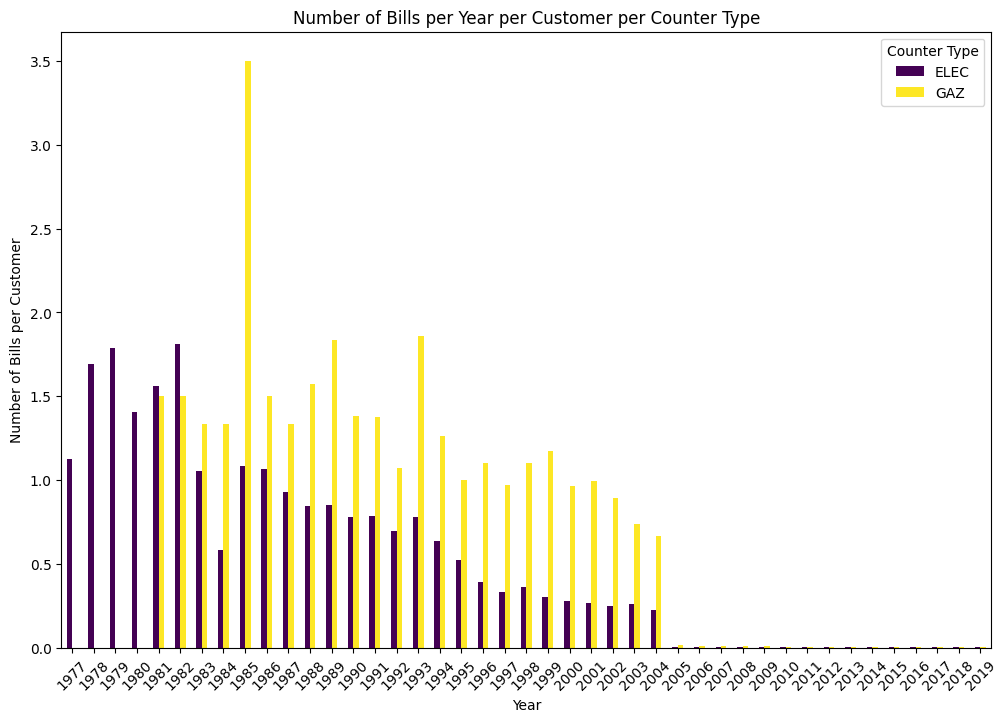

In [57]:
# Calculate the number of unique invoice dates per counter_type and client
unique_invoice_dates = invoice.groupby(['counter_type', 'client_id'])['invoice_date'].nunique()

# Calculate the number of invoice dates per year per client and counter type
invoice['invoice_year'] = pd.to_datetime(invoice['invoice_date']).dt.year
invoice_dates_per_year = invoice.groupby(['counter_type', 'client_id', 'invoice_year'])['invoice_date'].nunique()

# Calculate the number of customers per year per counter type
customers_per_year = invoice.groupby(['counter_type', 'invoice_year'])['client_id'].nunique().reset_index()
customers_per_year.rename(columns={'client_id': 'num_customers'}, inplace=True)

# Calculate the number of bills per year divided by the number of customers per year
invoice_counts = invoice.groupby(['counter_type', 'invoice_year'])['invoice_date'].nunique().reset_index()
invoice_counts = invoice_counts.merge(customers_per_year, on=['counter_type', 'invoice_year'])
invoice_counts['bills_per_customer'] = invoice_counts['invoice_date'] / invoice_counts['num_customers']

# Plot the number of bills per year divided by the number of customers per year
invoice_counts_pivot = invoice_counts.pivot(index='invoice_year', columns='counter_type', values='bills_per_customer')
invoice_counts_pivot.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Number of Bills per Year per Customer per Counter Type')
plt.xlabel('Year')
plt.ylabel('Number of Bills per Customer')
plt.xticks(rotation=45)
plt.legend(title='Counter Type')
plt.show()

In [58]:
# which customer with 3.5 invoices in counter_type= Gaz in 1985
invoice.counter_type.unique()
invoice.columns
# get number of invoive_dates per year and client_id
invoice_dates_per_year = invoice.groupby(['counter_type', 'client_id', 'invoice_year'])['invoice_date'].nunique().reset_index()

In [59]:
# aggregate (sum) the number of invoice_date per client per year per counter
# Aggregate data by counter_type, invoice_year, and client_id to get the sum of invoice_date
invoice_dates_per_year_counter = invoice_dates_per_year[invoice_dates_per_year['invoice_date'] > 0].groupby(['counter_type', 'invoice_year', 'client_id'])['invoice_date'].sum().reset_index()
# Remove rows where the count is zero
invoice_dates_per_year_counter = invoice_dates_per_year_counter[invoice_dates_per_year_counter['invoice_date'] > 0]

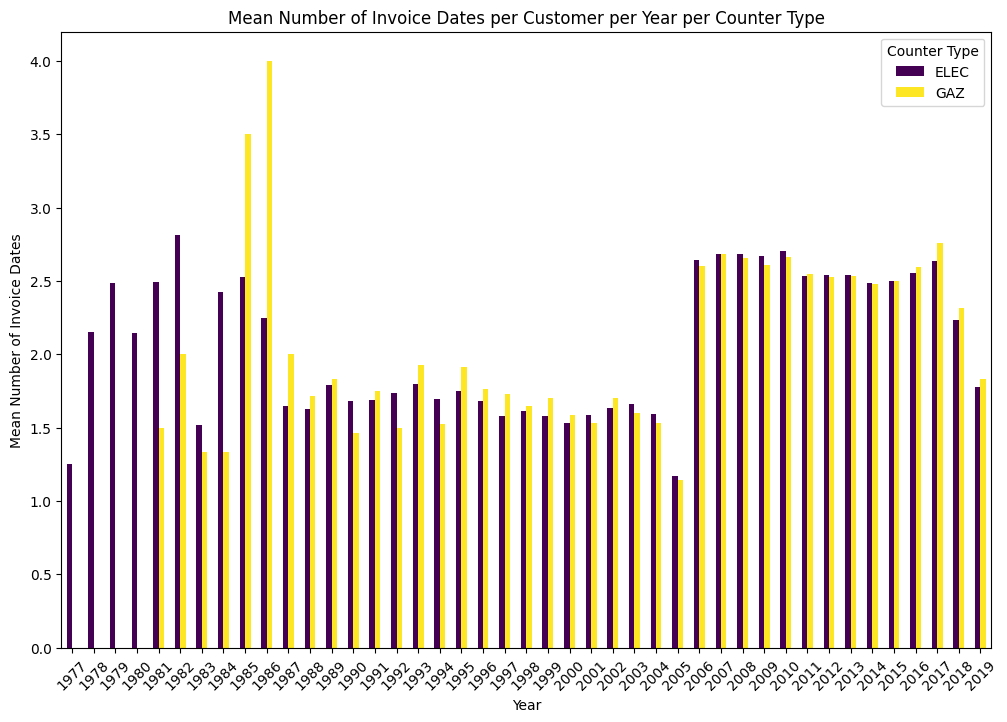

In [60]:
# mean number of invoice_date per customer per year per counter type, counter types as categoty
# Aggregate data by counter_type, invoice_year, and client_id to get the mean of invoice_date
invoice_dates_per_year_counter_mean = invoice_dates_per_year_counter.groupby(['counter_type', 'invoice_year'])['invoice_date'].mean().reset_index()
invoice_dates_per_year_counter_mean['counter_type'] = invoice_dates_per_year_counter_mean['counter_type'].astype('category')

# Plot the mean number of invoice dates per customer per year per counter type
invoice_dates_per_year_counter_mean_pivot = invoice_dates_per_year_counter_mean.pivot(index='invoice_year', columns='counter_type', values='invoice_date')
invoice_dates_per_year_counter_mean_pivot.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Mean Number of Invoice Dates per Customer per Year per Counter Type')
plt.xlabel('Year')
plt.ylabel('Mean Number of Invoice Dates')
plt.xticks(rotation=45)
plt.legend(title='Counter Type')
plt.show()

In [61]:
# how many invoive dates each client has per year on average
invoice_dates_per_year_counter_mean_client = invoice_dates_per_year_counter.groupby(['counter_type', 'invoice_year', 'client_id'])['invoice_date'].mean().reset_index()
invoice_dates_per_year_counter_mean_client['counter_type'] = invoice_dates_per_year_counter_mean_client['counter_type'].astype('category')

# how many invoice_dates larger than 1 per clients_id and year and counter type
invoice_dates_per_year_counter_mean_client = invoice_dates_per_year_counter_mean_client[invoice_dates_per_year_counter_mean_client['invoice_date'] > 1]
# extract client names from invoice_dates_per_year_counter_mean_client
client_names = invoice_dates_per_year_counter_mean_client['client_id'].unique()
# get all rows from invoice with client_id in client_names
invoice_clients = invoice[invoice['client_id'].isin(client_names)]
# get month of invoice_date
invoice_clients['month'] = pd.to_datetime(invoice_clients['invoice_date']).dt.month
invoice_clients['month'].unique()

# get from invoice df on ly those cliend_id where, where invoice was sent in every month of a year
invoice_clients['year'] = pd.to_datetime(invoice_clients['invoice_date']).dt.year
invoice_clients['month'] = pd.to_datetime(invoice_clients['invoice_date']).dt.month

C:\Users\mannt\AppData\Local\Temp\ipykernel_38932\3698166744.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_clients['month'] = pd.to_datetime(invoice_clients['invoice_date']).dt.month
C:\Users\mannt\AppData\Local\Temp\ipykernel_38932\3698166744.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoice_clients['year'] = pd.to_datetime(invoice_clients['invoice_date']).dt.year
C:\Users\mannt\AppData\Local\Temp\ipykernel_38932\3698166744.py:17: SettingWithCopyWarning: 
A value is trying to be s

In [62]:
# remove old index and new index
invoice = invoice.drop(columns=['old_index', 'new_index'], axis=1)
# count counter_coefficient per counter_type

In [ ]:
# table with counts of counter_type per target and counter coefficient for target=1
counter_coefficient_counts = invoice[invoice['target'] == 1].groupby(['target',
                                                                      'counter_type',
                                                                      'counter_coefficient']).size().reset_index(name='count')
counter_coefficient_pivot = counter_coefficient_counts.pivot_table(index=['target', 'counter_type'], 
                                                                   columns='counter_coefficient', values='count', fill_value=0)
print(counter_coefficient_pivot)

counter_coefficient  0       1   5   10
target counter_type                    
1.0    ELEC           1  236343   0   1
       GAZ            0  116763   1   0


In [64]:
# table with counts of counter_type per target and counter_status for target=1
counter_status_counts = invoice[invoice['target'] == 1].groupby(['target', 'counter_type', 'counter_status']).size().reset_index(name='count')
counter_status_pivot = counter_status_counts.pivot_table(index=['target', 'counter_type'], columns='counter_status', values='count', fill_value=0)
print(counter_status_pivot)
invoice.counter_status.unique()

counter_status            0     1  2   3    4     5
target counter_type                                
1.0    ELEC          231604  2871  0  17  221  1632
       GAZ           113691  2531  2   2   14   524


<IntegerArray>
[0, 1, 5, 4, 3, 2, <NA>]
Length: 7, dtype: Int64

   target counter_type  unique_counter_status_count
0     1.0         ELEC                            5
1     1.0          GAZ                            6
    target counter_type  counter_status   count
0      1.0         ELEC               0  231604
1      1.0         ELEC               1    2871
2      1.0         ELEC               3      17
3      1.0         ELEC               4     221
4      1.0         ELEC               5    1632
5      1.0          GAZ               0  113691
6      1.0          GAZ               1    2531
7      1.0          GAZ               2       2
8      1.0          GAZ               3       2
9      1.0          GAZ               4      14
10     1.0          GAZ               5     524


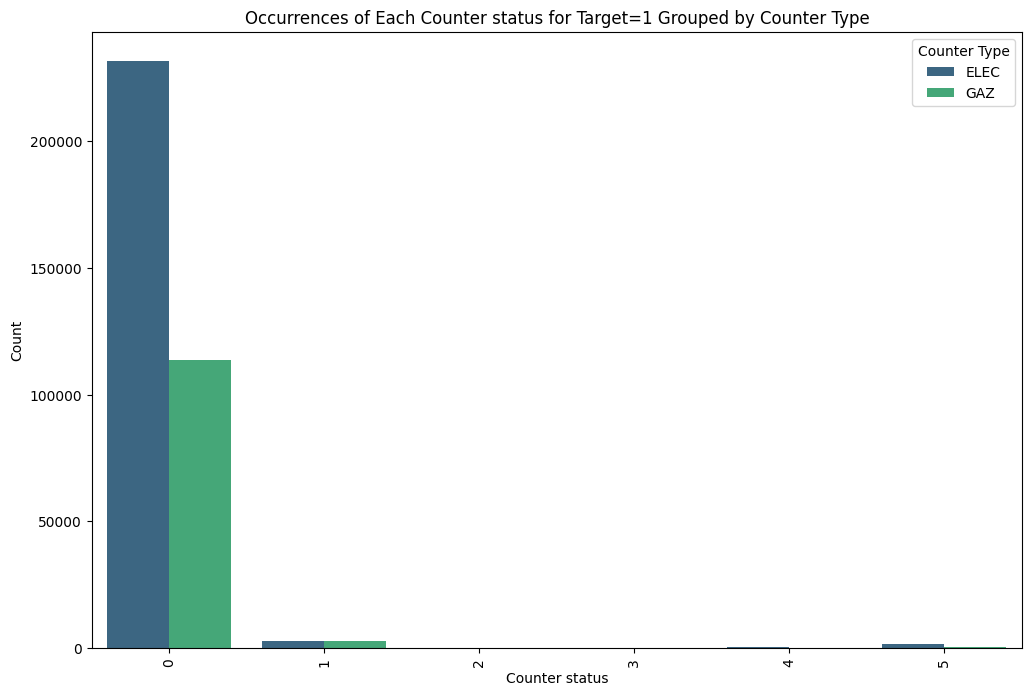

In [65]:
# Count unique values of counter_status for target=1 grouped by counter_type
counter_status_unique_counts = invoice[invoice['target'] == 1].groupby(['target', 'counter_type'])['counter_status'].nunique().reset_index(name='unique_counter_status_count')
print(counter_status_unique_counts)

# Count occurrences of each counter_status for target=1 grouped by counter_type
counter_status_counts_per_target = invoice[invoice['target'] == 1].groupby(['target', 'counter_type', 'counter_status']).size().reset_index(name='count')
print(counter_status_counts_per_target)

# Plot occurrences of each counter_status for target=1 grouped by counter_type
plt.figure(figsize=(12, 8))
sns.barplot(data=counter_status_counts_per_target, x='counter_status', y='count', hue='counter_type', palette='viridis')
plt.title('Occurrences of Each Counter status for Target=1 Grouped by Counter Type')
plt.xlabel('Counter status')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Counter Type')
plt.show()
# note: the fraudulent people have 0 mostly as counter_status



   target counter_type  unique_reading_remarque_count
0     1.0         ELEC                              3
1     1.0          GAZ                              4
   target counter_type  reading_remark   count
0     1.0         ELEC               6  111482
1     1.0         ELEC               8   43137
2     1.0         ELEC               9   81726
3     1.0          GAZ               6   60453
4     1.0          GAZ               7       1
5     1.0          GAZ               8   24632
6     1.0          GAZ               9   31678


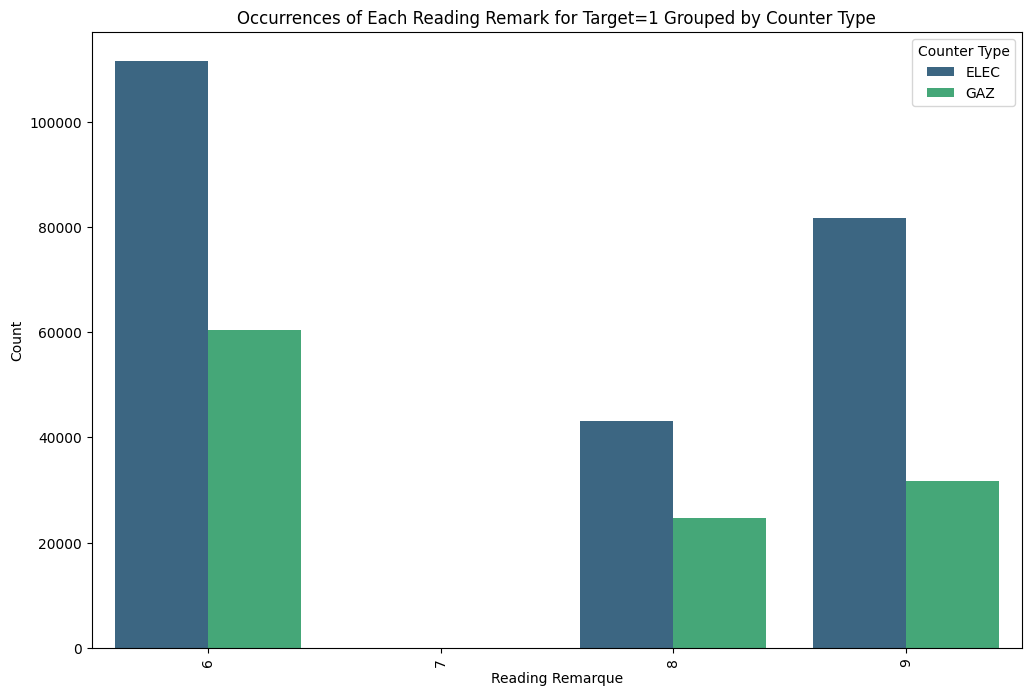

In [66]:
# Count unique values of reading_remarque for target=1 grouped by counter_type
reading_remarque_unique_counts = invoice[invoice['target'] == 1].groupby(['target', 'counter_type'])['reading_remark'].nunique().reset_index(name='unique_reading_remarque_count')
print(reading_remarque_unique_counts)

# Count occurrences of each reading_remarque for target=1 grouped by counter_type
reading_remarque_counts_per_target = invoice[invoice['target'] == 1].groupby(['target', 'counter_type', 'reading_remark']).size().reset_index(name='count')
print(reading_remarque_counts_per_target)

# Plot occurrences of each reading_remarque for target=1 grouped by counter_type
plt.figure(figsize=(12, 8))
sns.barplot(data=reading_remarque_counts_per_target, x='reading_remark', y='count', hue='counter_type', palette='viridis')
plt.title('Occurrences of Each Reading Remark for Target=1 Grouped by Counter Type')
plt.xlabel('Reading Remarque')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Counter Type')
plt.show()
# note: the fraudulent people have mostly 6,8,9 as reading_remarque

   target counter_type  unique_tarif_type_count
0     1.0         ELEC                       11
1     1.0          GAZ                        2
    target counter_type  tariff_type   count
0      1.0         ELEC            8       1
1      1.0         ELEC            9     444
2      1.0         ELEC           10   24605
3      1.0         ELEC           11  197382
4      1.0         ELEC           12    1264
5      1.0         ELEC           13    1301
6      1.0         ELEC           14    1302
7      1.0         ELEC           15    8933
8      1.0         ELEC           18       4
9      1.0         ELEC           21      11
10     1.0         ELEC           29    1098
11     1.0          GAZ           40  113422
12     1.0          GAZ           45    3342


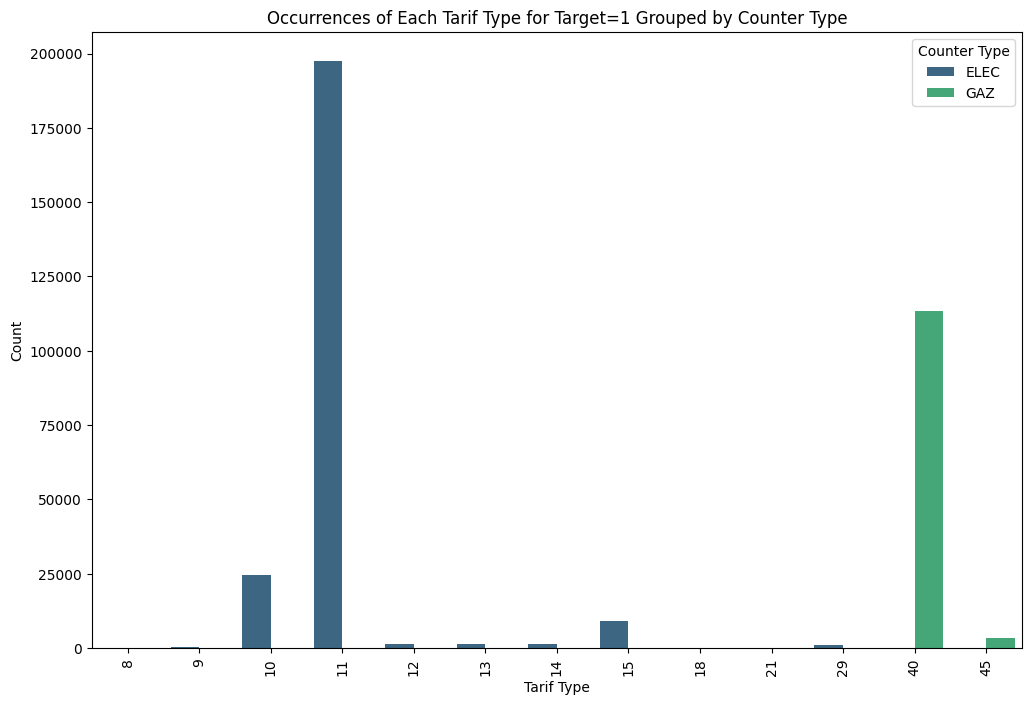

In [67]:
# Count unique values of tarif_type for target=1 grouped by counter_type
tarif_type_unique_counts = invoice[invoice['target'] == 1].groupby(['target', 'counter_type'])['tariff_type'].nunique().reset_index(name='unique_tarif_type_count')
print(tarif_type_unique_counts)

# Count occurrences of each tarif_type for target=1 grouped by counter_type
tarif_type_counts_per_target = invoice[invoice['target'] == 1].groupby(['target', 'counter_type', 'tariff_type']).size().reset_index(name='count')
print(tarif_type_counts_per_target)

# Plot occurrences of each tarif_type for target=1 grouped by counter_type
plt.figure(figsize=(12, 8))
sns.barplot(data=tarif_type_counts_per_target, x='tariff_type', y='count', hue='counter_type', palette='viridis')
plt.title('Occurrences of Each Tarif Type for Target=1 Grouped by Counter Type')
plt.xlabel('Tarif Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Counter Type')
plt.show()
# note: the fraudulent people have mostly specific tarif types 11, 10, 40 and a few others

   target counter_type  unique_counter_coefficient_count
0     1.0         ELEC                                 3
1     1.0          GAZ                                 2
   target counter_type  counter_coefficient   count
0     1.0         ELEC                    0       1
1     1.0         ELEC                    1  236343
2     1.0         ELEC                   10       1
3     1.0          GAZ                    1  116763
4     1.0          GAZ                    5       1


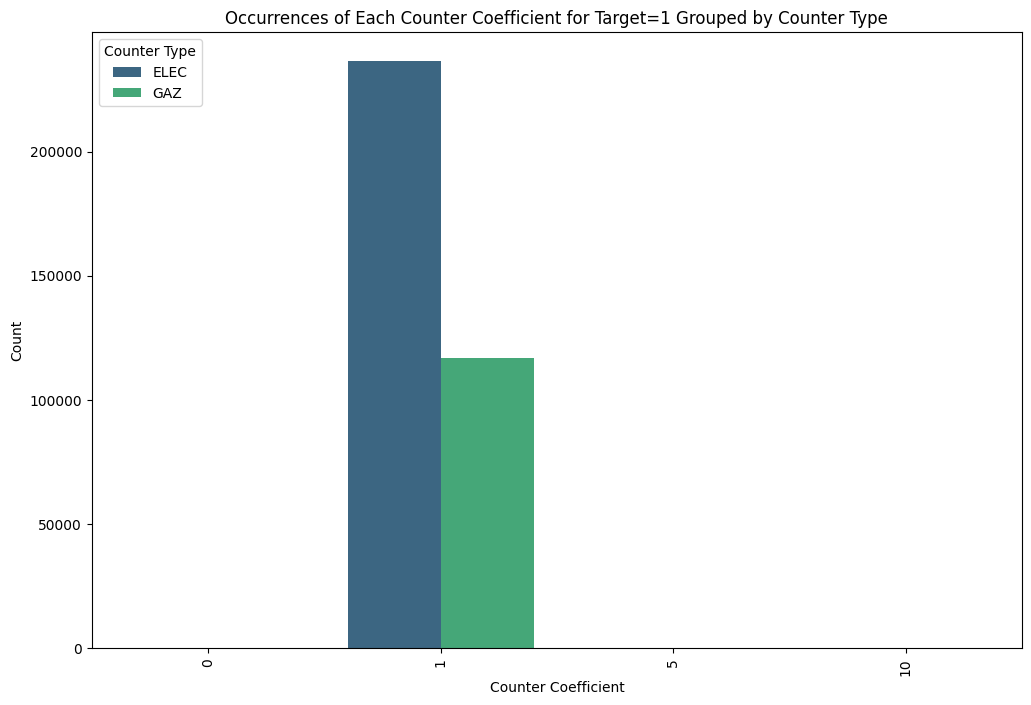

In [68]:
# Count unique values of counter_coefficient for target=1 grouped by counter_type
counter_coefficient_unique_counts = invoice[invoice['target'] == 1].groupby(['target', 'counter_type'])['counter_coefficient'].nunique().reset_index(name='unique_counter_coefficient_count')
print(counter_coefficient_unique_counts)

# Count occurrences of each counter_coefficient for target=1 grouped by counter_type
counter_coefficient_counts_per_target = invoice[invoice['target'] == 1].groupby(['target', 'counter_type', 'counter_coefficient']).size().reset_index(name='count')
print(counter_coefficient_counts_per_target)

# Plot occurrences of each counter_coefficient for target=1 grouped by counter_type
plt.figure(figsize=(12, 8))
sns.barplot(data=counter_coefficient_counts_per_target, x='counter_coefficient', y='count', hue='counter_type', palette='viridis')
plt.title('Occurrences of Each Counter Coefficient for Target=1 Grouped by Counter Type')
plt.xlabel('Counter Coefficient')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Counter Type')
plt.show()
# note: the fraudulent people have counter coefficients 1

In [70]:
# Count unique values of counter_coefficient for target=1 grouped by counter_type
consumption_level_1_unique_counts = invoice[invoice['target'] == 1].groupby(['target', 'counter_type'])['consumption_level_1'].nunique().reset_index(name='unique_consumption_level_1_count')
print(consumption_level_1_unique_counts)

# Count occurrences of each consommation_level_1 for target=1 grouped by counter_type
consumption_level_1_counts_per_target = invoice[invoice['target'] == 1].groupby(['target', 'counter_type', 'consumption_level_1']).size().reset_index(name='count')
print(consumption_level_1_counts_per_target)

# # Plot occurrences of each consommation_level_1 for target=1 grouped by counter_type
# plt.figure(figsize=(12, 8))
# sns.barplot(data=consumption_level_1_counts_per_target, x='consumption_level_1', y='count', hue='counter_type', palette='viridis')
# plt.title('Occurrences of Each Consommation Level 1 for Target=1 Grouped by Counter Type')
# plt.xlabel('Consommation Level 1')
# plt.ylabel('Count')
# plt.xticks(rotation=90)
# plt.legend(title='Counter Type')
# plt.show()
# # note: the fraudulent people have specific comsommation levels

   target counter_type  unique_consumption_level_1_count
0     1.0         ELEC                              3170
1     1.0          GAZ                              3612
      target counter_type  consumption_level_1  count
0        1.0         ELEC                    0  19695
1        1.0         ELEC                    1    854
2        1.0         ELEC                    2    429
3        1.0         ELEC                    3    310
4        1.0         ELEC                    4    338
...      ...          ...                  ...    ...
6777     1.0          GAZ                20933      1
6778     1.0          GAZ                21817      1
6779     1.0          GAZ                24557      1
6780     1.0          GAZ                28033      1
6781     1.0          GAZ                28987      1

[6782 rows x 4 columns]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

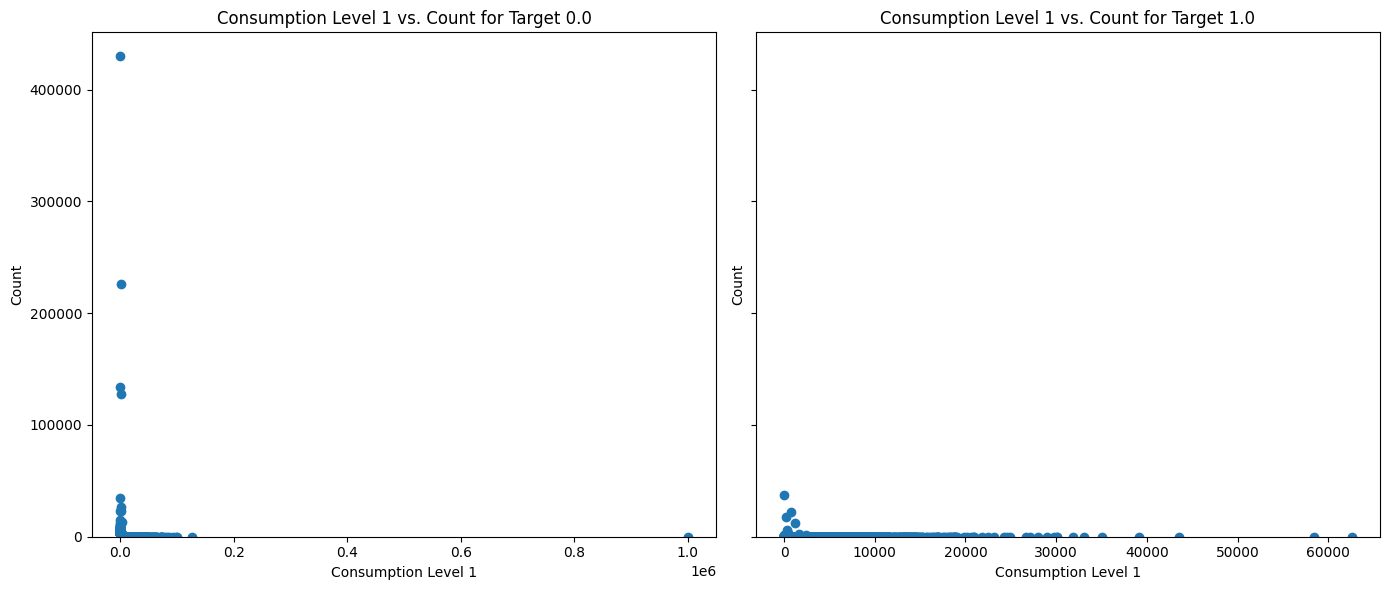

In [71]:
len(invoice.consumption_level_1.unique())
# unique sorted ascending values from consumption_level_1
unique_sorted_values = sorted(invoice['consumption_level_1'].unique())
print(unique_sorted_values)
# consumption_level_1 per target = 1
consumption_level_1_target_1 = invoice[invoice['target'] == 1]['consumption_level_1']
# sort ascending and check if sequence is continuously +1
unique_sorted_values_target_1 = sorted(consumption_level_1_target_1.unique())
# scatterplot consumption_level_1(x) over target count(y) side by side for each target
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for target, ax in zip(invoice['target'].unique(), axes):
    consumption_level_1_target = invoice[invoice['target'] == target]['consumption_level_1']
    unique_sorted_values_target = sorted(consumption_level_1_target.unique())
    ax.scatter(unique_sorted_values_target, consumption_level_1_target.value_counts().sort_index())
    ax.set_xlabel('Consumption Level 1')
    ax.set_ylabel('Count')
    ax.set_title(f'Consumption Level 1 vs. Count for Target {target}')
    ax.set_ylim(bottom=0)  # Free y-axis

plt.tight_layout()
plt.show()

In [72]:
# Boxplot for all columns containing "consumption" in the column name
consumption_columns = [col for col in invoice.columns if 'consumption' in col]
# pivot: one consumption level with consumption columns values

# for each consumption_columns, aggregate mean per client_id and counter_type
consumption_columns_agg = invoice.groupby(['client_id', 'counter_type'])[consumption_columns].mean().reset_index()
# pivot to long format consumption_columns

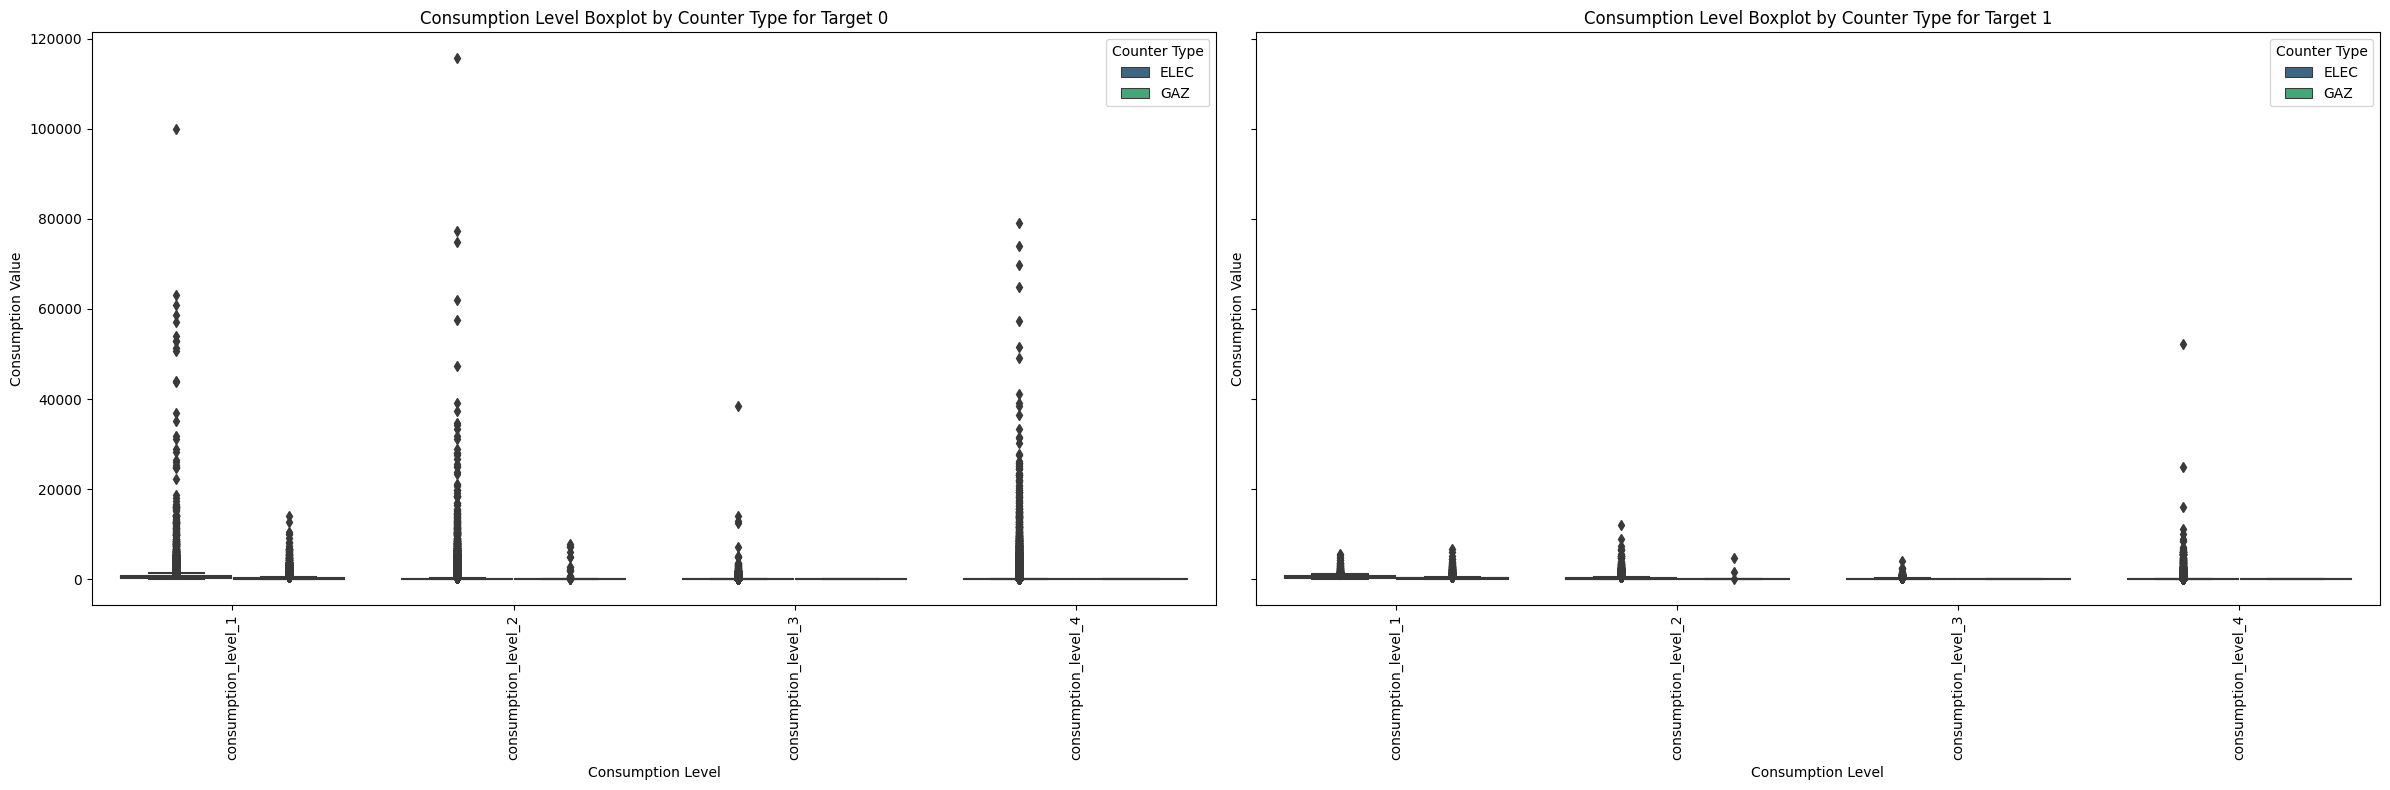

In [73]:
consumption_columns_long = pd.melt(consumption_columns_agg, id_vars=['client_id', 'counter_type'], value_vars=consumption_columns, var_name='consumption_level', value_name='consumption_value')
# merge target from invoice to consumption_columns_long
consumption_columns_long = consumption_columns_long.merge(invoice[['client_id', 'target']].drop_duplicates(), on='client_id', how='left')

# plot consumption_columns_long side by side for target=1 and target=0
fig, axes = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

for target, ax in zip([0, 1], axes):
    sns.boxplot(data=consumption_columns_long[consumption_columns_long['target'] == target], x='consumption_level', y='consumption_value', hue='counter_type', palette='viridis', ax=ax)
    ax.set_title(f'Consumption Level Boxplot by Counter Type for Target {target}')
    ax.set_xlabel('Consumption Level')
    ax.set_ylabel('Consumption Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='Counter Type')

plt.tight_layout()
plt.show()  

In [74]:
# export updated invoice table
invoice.to_csv('data/raw/invoice_updated.csv', index=False)